# Perform Bayesian optimization of CrabNet hyperparameters using Ax

###### Created January 8, 2022

# Description

We use [(my fork of) CrabNet](https://github.com/sgbaird/CrabNet) to adjust various hyperparameters for the experimental band gap matbench task (`matbench_expt_gap`). We chose this task because `CrabNet` is currently (2021-01-08) listed at the top of this leaderboard (with `MODNet` just marginally worse) which is likely related to it being a composition-only dataset (`CrabNet` is a composition-only model).

The question we're asking in this additional `matbench` submission is:
**When a model whose defaults already produce state-of-the-art property prediction performance, to what extent can it benefit from hyperparameter optimization (i.e. tuning parameters such as Neural Network dimensions, learning rates, etc.)?**

Eventually, I plan to incorporate this into (my fork of) `CrabNet`, but for now this can serve as an illustrative example of hyperparameter optimization using Bayesian adaptive design and could certainly be adapted to other models, especially expensive-to-train models (e.g. neural networks) that have not undergone much by way of parameter tuning.

[facebook/Ax](https://github.com/facebook/Ax) is used as the backend for performing Bayesian adaptive design.

For additional files related to this `matbench` submission, see the [crabnet-hyperparameter](https://github.com/sparks-baird/crabnet-hyperparameter) repository.

# Benchmark name
Matbench v0.1

# Package versions
- ax_platform==0.2.3
- crabnet==1.2.1
- scikit_learn==1.0.2
- matbench==0.5
- kaleido==0.2.1

# Algorithm description
Use Ax Bayesian adaptive design to simultaneously optimize 23 hyperparameters of CrabNet. `100` sequential design iterations were used, and parameters were chosen based on a combination of intuition and algorithm/data constraints (e.g. elemental featurizers which were missing elements contained in the dataset were removed). The first `46` iterations (`23*2` parameters) were based on SOBOL sampling to create a rough initial model, while the remaining `56` iterations were Bayesian adaptive design iterations. For the inner loops (where hyperparameter optimization is performed), the average MAE across each of the *five inner folds* was used as Ax's objective to minimize. The best parameter set was then trained on all the inner fold data and used to predict on the test set (unknown during hyperparameter optimization). This is nested cross-validation (CV), and is computationally expensive. See [automatminer: running a benchmark](https://hackingmaterials.lbl.gov/automatminer/advanced.html#running-a-benchmark) for more information on nested CV.

## Imports

In [ ]:
import pprint
from os.path import join
from pathlib import Path
import numpy as np
import pandas as pd

import plotly.graph_objects as go

import gc
import torch

from ax.storage.json_store.save import save_experiment
from ax.plot.trace import optimization_trace_single_method
from ax.service.managed_loop import optimize
import crabnet
from crabnet.train_crabnet import get_model
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold

from matbench.bench import MatbenchBenchmark

## Setup

`dummy` lets you swap between a fast run and a more comprehensive run. The more comprehensive run was used for this matbench submission.

In [ ]:
dummy = False
if dummy:
    n_splits = 2
    total_trials = 2
else:
    n_splits = 5
    total_trials = 100

Specify directories where you want to save things and make sure they exist.

In [ ]:
# create dir https://stackoverflow.com/a/273227/13697228
experiment_dir = "experiments"
figure_dir = "figures"
Path(experiment_dir).mkdir(parents=True, exist_ok=True)
Path(figure_dir).mkdir(parents=True, exist_ok=True)

## Helper Functions

### matplotlibify

The following code makes a Plotly figure look more like a matplotlib figure to make it easier to include in a manuscript.

In [ ]:
def matplotlibify(fig, size=24, width_inches=3.5, height_inches=3.5, dpi=142):
    # make it look more like matplotlib
    # modified from: https://medium.com/swlh/formatting-a-plotly-figure-with-matplotlib-style-fa56ddd97539)
    font_dict = dict(family="Arial", size=size, color="black")

    fig.update_layout(
        font=font_dict,
        plot_bgcolor="white",
        width=width_inches * dpi,
        height=height_inches * dpi,
        margin=dict(r=40, t=20, b=10),
    )

    fig.update_yaxes(
        showline=True,  # add line at x=0
        linecolor="black",  # line color
        linewidth=2.4,  # line size
        ticks="inside",  # ticks outside axis
        tickfont=font_dict,  # tick label font
        mirror="allticks",  # add ticks to top/right axes
        tickwidth=2.4,  # tick width
        tickcolor="black",  # tick color
    )

    fig.update_xaxes(
        showline=True,
        showticklabels=True,
        linecolor="black",
        linewidth=2.4,
        ticks="inside",
        tickfont=font_dict,
        mirror="allticks",
        tickwidth=2.4,
        tickcolor="black",
    )
    fig.update(layout_coloraxis_showscale=False)

    width_default_px = fig.layout.width
    targ_dpi = 300
    scale = width_inches / (width_default_px / dpi) * (targ_dpi / dpi)

    return fig, scale

### correct_parameterization

The following function is very important for interfacing Ax with CrabNet. The information in `parameterization` (a Python `dict`) as an input and `parameterization` as an output (please excuse the faux pas) is essentially the same, but Ax needs a representation for the parameter space and CrabNet has a certain API for the parameters. `correct_parameterization` just converts from the Ax representation of CrabNet parameters to the CrabNet API for parameters.

In [ ]:
def correct_parameterization(parameterization):
    pprint.pprint(parameterization)

    parameterization["out_hidden"] = [
        parameterization.get("out_hidden4") * 8,
        parameterization.get("out_hidden4") * 4,
        parameterization.get("out_hidden4") * 2,
        parameterization.get("out_hidden4"),
    ]
    parameterization.pop("out_hidden4")

    parameterization["betas"] = (
        parameterization.get("betas1"),
        parameterization.get("betas2"),
    )
    parameterization.pop("betas1")
    parameterization.pop("betas2")

    d_model = parameterization["d_model"]

    # make heads even (unless it's 1) (because d_model must be even)
    heads = parameterization["heads"]
    if np.mod(heads, 2) != 0:
        heads = heads + 1
    parameterization["heads"] = heads

    # NOTE: d_model must be divisible by heads
    d_model = parameterization["heads"] * round(d_model / parameterization["heads"])

    parameterization["d_model"] = d_model

    parameterization["pos_scaler_log"] = (
        1 - parameterization["emb_scaler"] - parameterization["pos_scaler"]
    )

    parameterization["epochs"] = parameterization["epochs_step"] * 4

    return parameterization

## Hyperparameter Optimization (and matbench recording)

Note that `crabnet_mae` is defined inside of the loop so that `train_val_df` object is updated for each outer fold. This is due to a limitation of Ax where `crabnet_mae` (the objective function) can *only* take parameterization as an input (no additional parameters, kwargs, etc.). This was my workaround. Note that for the inner loop where Ax optimizes the CrabNet parameters for each outer fold, five inner folds are used, and the objective that Ax optimizes is the average MAE across the five inner folds. Additionally, hyperparameter optimization plots are produced for each of the five outer folds (Ax objective vs. iteration) using `100` sequential iterations. In other words, for a single `matbench` task (this notebook), `CrabNet` undergoes model instantiation and fitting `5*5*100 --> 2500` times. This took a few days to run on a single machine.

In [ ]:
mb = MatbenchBenchmark(autoload=False, subset=["matbench_expt_gap"])
kf = KFold(n_splits=n_splits, shuffle=True, random_state=18012019)

task = list(mb.tasks)[0]
task.load()
for i, fold in enumerate(task.folds):
    train_inputs, train_outputs = task.get_train_and_val_data(fold)

    # TODO: treat train_val_df as Ax fixed_parameter
    train_val_df = pd.DataFrame(
        {"formula": train_inputs.values, "target": train_outputs.values}
    )
    if dummy:
        train_val_df = train_val_df[:100]

    def crabnet_mae(parameterization):
        """Compute the mean absolute error of a CrabNet model.
        
        Assumes that `train_df` and `val_df` are predefined.

        Parameters
        ----------
        parameterization : dict
            Dictionary of the parameters passed to `get_model()` after some slight
            modification. 

        Returns
        -------
        results: dict
            Dictionary of `{"rmse": rmse}` where `rmse` is the root-mean-square error of the
            CrabNet model.
        """
        parameterization = correct_parameterization(parameterization)

        mae = 0.0
        for train_index, val_index in kf.split(train_val_df):
            train_df, val_df = (
                train_val_df.loc[train_index],
                train_val_df.loc[val_index],
            )
            crabnet_model = get_model(
                mat_prop="expt_gap",
                train_df=train_df,
                learningcurve=False,
                force_cpu=False,
                **parameterization
            )
            val_true, val_pred, val_formulas, val_sigma = crabnet_model.predict(val_df)
            # rmse = mean_squared_error(val_true, val_pred, squared=False)
            mae = mae + mean_absolute_error(val_true, val_pred)

            # deallocate CUDA memory https://discuss.pytorch.org/t/how-can-we-release-gpu-memory-cache/14530/28
            del crabnet_model
            gc.collect()
            torch.cuda.empty_cache()
        mae = mae / n_splits
        results = {"mae": mae}
        return results

    best_parameters, values, experiment, model = optimize(
        parameters=[
            {"name": "batch_size", "type": "range", "bounds": [32, 256]},
            {"name": "fudge", "type": "range", "bounds": [0.0, 0.1]},
            {"name": "d_model", "type": "range", "bounds": [100, 1024]},
            {"name": "N", "type": "range", "bounds": [1, 10]},
            {"name": "heads", "type": "range", "bounds": [1, 10]},
            {"name": "out_hidden4", "type": "range", "bounds": [32, 512]},
            {"name": "emb_scaler", "type": "range", "bounds": [0.0, 1.0]},
            {"name": "pos_scaler", "type": "range", "bounds": [0.0, 1.0]},
            {"name": "bias", "type": "choice", "values": [False, True]},
            {"name": "dim_feedforward", "type": "range", "bounds": [1024, 4096],},
            {"name": "dropout", "type": "range", "bounds": [0.0, 1.0]},
            # jarvis and oliynyk don't have enough elements
            # ptable contains str, which isn't a handled case
            {
                "name": "elem_prop",
                "type": "choice",
                "values": [
                    "mat2vec",
                    "magpie",
                    "onehot",
                ],  # "jarvis", "oliynyk", "ptable"
            },
            {"name": "epochs_step", "type": "range", "bounds": [5, 20]},
            {"name": "pe_resolution", "type": "range", "bounds": [2500, 10000]},
            {"name": "ple_resolution", "type": "range", "bounds": [2500, 10000],},
            {
                "name": "criterion",
                "type": "choice",
                "values": ["RobustL1", "RobustL2"],
            },
            {"name": "lr", "type": "range", "bounds": [0.0001, 0.006]},
            {"name": "betas1", "type": "range", "bounds": [0.5, 0.9999]},
            {"name": "betas2", "type": "range", "bounds": [0.5, 0.9999]},
            {"name": "eps", "type": "range", "bounds": [0.0000001, 0.0001]},
            {"name": "weight_decay", "type": "range", "bounds": [0.0, 1.0]},
            # {"name": "adam", "type": "choice", "values": [False, True]}, # issues with onehot
            # {"name": "min_trust", "type": "range", "bounds": [0.0, 1.0]}, #issues with onehot
            {"name": "alpha", "type": "range", "bounds": [0.0, 1.0]},
            {"name": "k", "type": "range", "bounds": [2, 10]},
        ],
        experiment_name="crabnet-hyperparameter",
        evaluation_function=crabnet_mae,
        objective_name="mae",
        minimize=True,
        parameter_constraints=["betas1 <= betas2", "emb_scaler + pos_scaler <= 1"],
        total_trials=total_trials,
    )
    print(best_parameters)
    print(values)

    experiment_fpath = join(experiment_dir, "experiment" + str(i) + ".json")
    save_experiment(experiment, experiment_fpath)

    # TODO: save plot, save experiment

    test_inputs, test_outputs = task.get_test_data(fold, include_target=True)

    test_df = pd.DataFrame({"formula": test_inputs, "target": test_outputs})

    default_model = get_model(
        mat_prop="expt_gap",
        train_df=train_val_df,
        learningcurve=False,
        force_cpu=False,
    )

    default_true, default_pred, default_formulas, default_sigma = default_model.predict(
        test_df
    )
    # rmse = mean_squared_error(val_true, val_pred, squared=False)
    default_mae = mean_absolute_error(default_true, default_pred)

    # deallocate CUDA memory https://discuss.pytorch.org/t/how-can-we-release-gpu-memory-cache/14530/28
    del default_model
    gc.collect()
    torch.cuda.empty_cache()

    best_parameterization = correct_parameterization(best_parameters)
    test_model = get_model(
        mat_prop="expt_gap",
        train_df=train_val_df,
        learningcurve=False,
        force_cpu=False,
        **best_parameterization
    )
    # TODO: update CrabNet predict function to allow for no target specified
    test_true, test_pred, test_formulas, test_sigma = test_model.predict(test_df)
    # rmse = mean_squared_error(val_true, val_pred, squared=False)
    test_mae = mean_absolute_error(test_true, test_pred)

    # deallocate CUDA memory https://discuss.pytorch.org/t/how-can-we-release-gpu-memory-cache/14530/28
    del test_model
    gc.collect()
    torch.cuda.empty_cache()

    trials = experiment.trials.values()

    best_objectives = np.array([[trial.objective_mean for trial in trials]])

    parameter_strs = [
        pprint.pformat(trial.arm.parameters).replace("\n", "<br>") for trial in trials
    ]

    best_objective_plot = optimization_trace_single_method(
        y=best_objectives,
        optimization_direction="minimize",
        ylabel="MAE (eV)",
        hover_labels=parameter_strs,
        plot_trial_points=True,
    )

    figure_fpath = join(figure_dir, "best_objective_plot_" + str(i))

    data = best_objective_plot[0]["data"]

    data.append(
        go.Scatter(
            x=(1, total_trials),
            y=(default_mae, default_mae),
            mode="lines",
            line={"dash": "dash"},
            name="default MAE",
            yaxis="y1",
        )
    )

    data.append(
        go.Scatter(
            x=(1, total_trials),
            y=(test_mae, test_mae),
            mode="lines",
            line={"dash": "dash"},
            name="best model test MAE",
            yaxis="y1",
        )
    )

    layout = best_objective_plot[0]["layout"]

    fig = go.Figure({"data": data, "layout": layout})

    fig.show()
    fig.write_html(figure_fpath + ".html")
    fig.to_json(figure_fpath + ".json")
    fig.update_layout(
        legend=dict(
            font=dict(size=16),
            yanchor="top",
            y=0.99,
            xanchor="right",
            x=0.99,
            bgcolor="rgba(0,0,0,0)",
        )
    )
    fig, scale = matplotlibify(fig)
    fig.write_image(figure_fpath + ".png")

    task.record(fold, test_pred, params=best_parameterization)

## Export matbench file

In [ ]:
my_metadata = {"algorithm_version": crabnet.__version__}
mb.add_metadata(my_metadata)
mb.to_file("expt_gap_benchmark.json.gz")

## Static Plots

For convenience (and so you don't have to run this notebook over the course of a few days), objective vs. iteration static plots are given for each of the five outer folds. If you'd like a more interactive experience, open the corresponding HTML files in your browser of choice from [`crabnet-hyperparameter/figures`](https://github.com/sparks-baird/crabnet-hyperparameter/tree/main/figures). Note that the first 46 (`2*23 parameters`) iterations are [SOBOL iterations](https://en.wikipedia.org/wiki/Sobol_sequence) (quasi-random sequence), and the remaining 54 are actual Bayesian optimization iterations.

In the last four out of five folds, the hyperparameter optimization results in a slightly better test MAE (i.e. MAE for data which was unknown during the hyperparameter optimization).

### Objective vs. iteration for outer fold 0

The best model test MAE is somewhat worse that the default test MAE, and both are close to the best validation MAE.

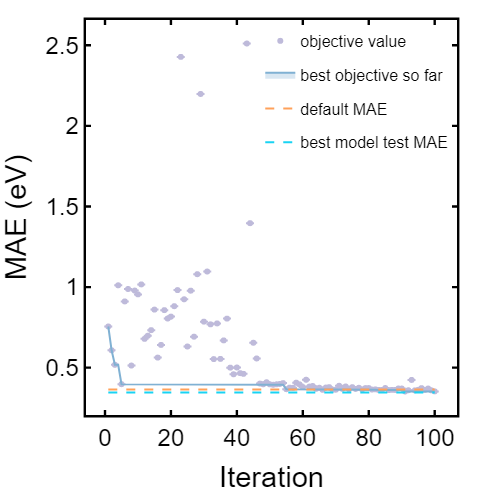

### Objective vs. iteration for outer fold 1

The best model test MAE is slightly better than the default test MAE.

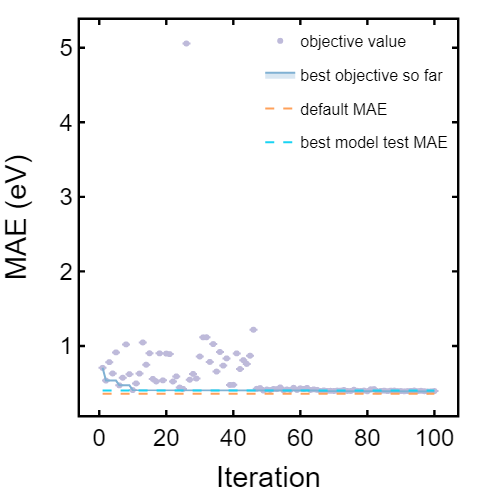

### Objective vs. iteration for outer fold 2

The best model test MAE is somewhat better than the default test MAE.

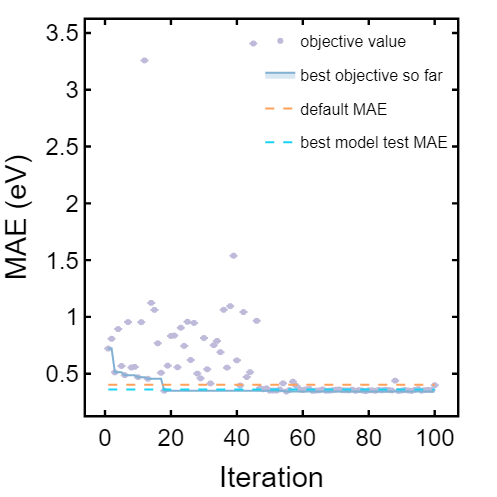

### Objective vs. iteration for outer fold 3

The best model test MAE is somewhat better than the default test MAE.

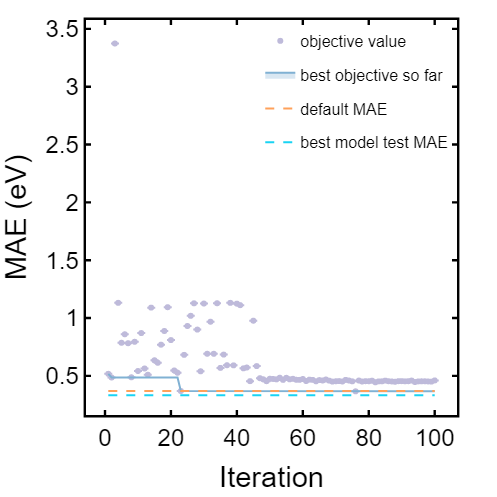

### Objective vs. iteration for outer fold 4

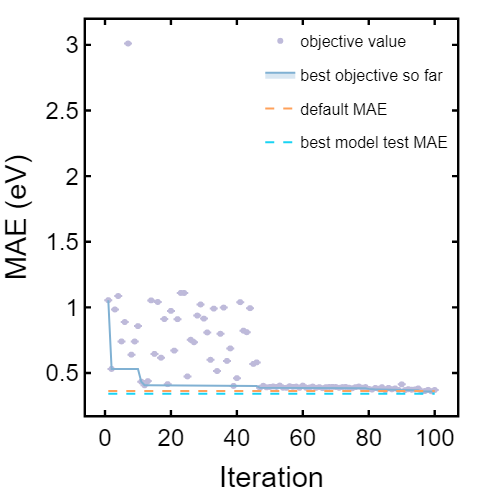